In [138]:
#!/usr/bin/env python3

import pandas as pd
import errno    
import os
import numpy as np
import math

#pd.set_option('display.max_rows', 4000)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

'''
Author: Enrico Ceccolini
    TODO write the description
'''

datadir = "/datasets/eurora_data/db1/"
infile_jobs_to_nodes = datadir + "job_nodes.csv"
infile_nodes = datadir + "nodes.csv"
infile_validate_approx = datadir + "CPUs/" + interval_comment + "/validate_approx_" + interval_comment + ".csv"

# settings
interval_comment = "Andrea"
suffix = "_1min_"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')

infile_large_jobs = datadir + "CPUs/" + interval_comment + "/large_jobs_real_pow_" + interval_comment + ".csv"

## notice that 43 doesn't exists in the db
#nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
#nodes=['01'] # test

In [139]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

interval_large_jobs = pd.read_csv(infile_large_jobs, index_col=0)
merged_jobs_to_nodes = pd.merge(jobs_to_nodes_whole_data, interval_large_jobs, on='job_id_string')
print(merged_jobs_to_nodes.shape[0])

jobs_to_nodes_whole_data contains 469095 records
after the clean, jobs_to_nodes_whole_data contains 444610 records
26913


In [140]:
nodes = pd.read_csv(infile_nodes, index_col=0)
print(nodes.shape[0])
nodes.head()

64


,node_id,cpu_type,core_idle
0,1,2_1_ghz,3.239357
1,2,2_1_ghz,3.284106
2,3,2_1_ghz,3.458403
3,4,2_1_ghz,3.394983
4,5,2_1_ghz,3.412616


In [141]:
#infile_node = datadir + "CPUs/" + interval_comment + "/node01" + suffix + interval_comment + "_active_cores_and_jobs"
#node_data = pd.read_csv(infile_node + ".csv")

#all_time_interval_power_consumption = pd.DataFrame(node_data['timestamp'])
#all_time_interval_power_consumption.to_csv(outfile_validate_approx)

all_time_interval_power_consumption = pd.read_csv(infile_validate_approx, index_col=0)
all_time_interval_power_consumption.shape

(44641, 1)

In [127]:
#all_time_interval_power_consumption

In [162]:

# per ogni nodo sommo quanto è stato il consumo ad ogni intervallo in un vettore parallelo
# questo sia per il valore approssimato guardando i job
# sia per il valore reale
j = 0
for node_index, node_row in nodes.iterrows():
    node_id = node_row['node_id']
    if( int(node_id) < 10):
        node_id = "0" + str(node_id)
    else:
        node_id = str(node_id)
    print(node_id)
    node_core_idle = node_row['core_idle']
    
    if (node_id != "43"):
        total_real_power_consumption, total_approx_power_consumption = calculate_power_consumption(node_id, node_core_idle)
        all_time_interval_power_consumption[node_id + "_real"] = total_real_power_consumption
        all_time_interval_power_consumption[node_id + "_approx"] = total_approx_power_consumption
    

    
    all_time_interval_power_consumption.to_csv(infile_validate_approx)

01
384
02
166
03
360
04
344
05
331
06
316
07
314
08
310
09
241
10
288
11
266
12
266
13
265
14
252
15
257
16
257
17
399
18
164
19
256
20
271
21
262
22
3
23
277
24
220
25
242
26
178
27
238
28
206
29
222
30
206
31
190
32
206
33
1429
34
918
35
771
36
820
37
682
38
678
39
88
40
649
41
3
42
601
43
44
981
45
992
46
588
47
497
48
518
49
563
50
568
51
512
52
246
53
12
54
533
55
953
56
549
57
564
58
524
59
484
60
518
61
543
62
535
63
511
64
926


In [100]:
#all_time_interval_power_consumption

In [157]:
def calculate_power_consumption(node_str, node_core_idle):
    
    num_minutes = 44641 # number of minutes on the Andrea's interval
    node_start_time = pd.to_datetime('2014-03-31 00:00:00')
    total_approx_power_consumption = pd.Series(0, index=np.arange(num_minutes))
    total_active_cores = pd.Series(0, index=np.arange(num_minutes))
    total_real_power_consumption = pd.Series(0, index=np.arange(num_minutes))
    
    jobs_to_node = merged_jobs_to_nodes[merged_jobs_to_nodes['node_id'] == int(node_str)]
    infile_node = datadir + "CPUs/" + interval_comment + "/node" + node_str + suffix + interval_comment + "_active_cores_and_jobs"
    node_data = pd.read_csv(infile_node + ".csv")
    #print("{}".format(node_data.shape[0]))
    #print("{}".format(jobs_to_node.shape[0]))

    #node_start_time = node_data.iloc[0]['timestamp']
    #num_minutes = node_data.shape[0]
    #power_consumption = pd.Series(0, index=np.arange(num_minutes))
    #active_cores = pd.Series(0, index=np.arange(num_minutes))
    #print("{}".format(node_start_time))
    
    power_consumption = pd.Series(0, index=np.arange(num_minutes))
    active_cores = pd.Series(0, index=np.arange(num_minutes))
    
    i = 0
    num_jobs = jobs_to_node.shape[0]
    print("{}".format(num_jobs))
    for job_index, job_row in jobs_to_node.iterrows():
        
        #print("{}/{}".format(i, num_jobs))
        i = i + 1
        job_start_time = pd.to_datetime(job_row['run_start_time'])
        job_end_time = pd.to_datetime(job_row['end_time'])
        job_cores = job_row['ncpus']
        job_cores_total = job_row['cpu_req']
        #job_gpus = row['ngpus']
        #job_mics = row['nmics']
        job_power_consumption = job_row['real_pow'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        # print(job_power_consumption)

        before_minutes = int((job_start_time - pd.to_datetime(node_start_time)) / np.timedelta64(1, 'm'))
        running_minutes = int((job_end_time - job_start_time) / np.timedelta64(1, 'm'))
        after_minutes = num_minutes - running_minutes - before_minutes

        #print("{} - {} - {}".format(before_minutes, running_minutes, after_minutes))
        before_serie = pd.Series(0, index=np.arange(before_minutes))
        running_serie = pd.Series(job_power_consumption, index=np.arange(running_minutes))
        after_serie = pd.Series(0, index=np.arange(after_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption = power_consumption.add(concat_series, fill_value=0)

        running_serie = pd.Series(job_cores, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        active_cores = active_cores.add(concat_series, fill_value=0)

        
    for x in range(0, 17):
        active_cores[active_cores == x] += (node_core_idle * 16) * (16 - x) / 16
    
    power_consumption = power_consumption.add(active_cores)
        
    total_real_power_consumption = node_data['pow_tot_0'] + node_data['pow_tot_1']
    return total_real_power_consumption, power_consumption

In [164]:
all_time_interval_power_consumption = all_time_interval_power_consumption[pd.to_datetime(all_time_interval_power_consumption['timestamp']) >= pd.to_datetime('2014-03-31 11:21:00')]
all_time_interval_power_consumption = all_time_interval_power_consumption[pd.to_datetime(all_time_interval_power_consumption['timestamp']) <= pd.to_datetime('2014-04-30 20:32:00')]

In [254]:
#all_time_interval_power_consumption = all_time_interval_power_consumption.fillna(55.52)

In [255]:
real = all_time_interval_power_consumption.select(lambda col: col.endswith("real"), axis=1)
approx = all_time_interval_power_consumption.select(lambda col: col.endswith("approx"), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  


In [256]:
real['Total']= real.iloc[:, -63:-1].sum(axis=1)
approx['Total']= approx.iloc[:, -63:-1].sum(axis=1)
differences = real['Total'] - approx['Total']
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df['Total']

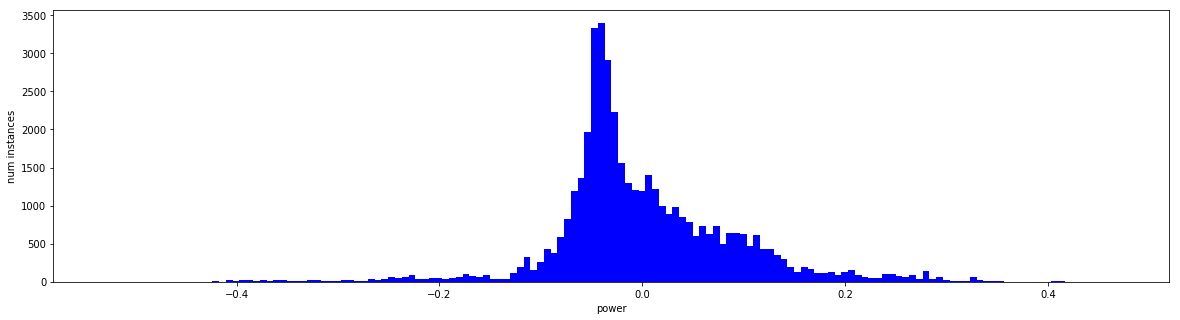

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

num_bins = 150
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
#plt.axis([-0.4, 0.4, 0, 600])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

43752


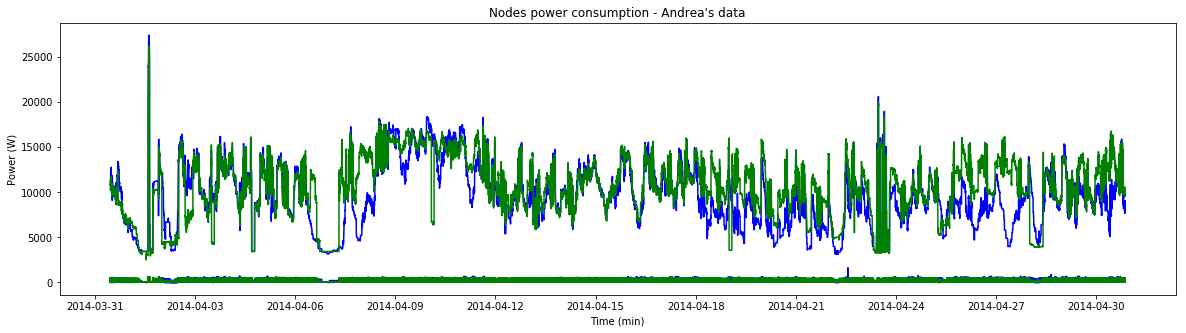

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

node_data = node_data[pd.to_datetime(node_data['timestamp']) >= start_time]
node_data = node_data[pd.to_datetime(node_data['timestamp']) <= end_time]

plt.rcParams['figure.figsize'] = (20,5)

X_AXIS_NAME = 'Time (min)'
Y_AXIS_NAME = 'Power (W)'
TITLE = 'Nodes power consumption - Andrea\'s data'

fig, ax = plt.subplots()
ax.xaxis.get_majorticklabels()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

dates = []
colors = ("blue", "green")

for ts in all_time_interval_power_consumption['timestamp']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
print(len(dates))

plt.plot(dates, approx, c=colors[0])

plt.plot(dates, real, c=colors[1], alpha=1)
#plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])


#fig.autofmt_xdate()
plt.xlabel(X_AXIS_NAME)
plt.ylabel(Y_AXIS_NAME)
plt.title(TITLE)

# function to show the plot
plt.show()
#fig.savefig('graph.png', dpi=fig.dpi)

In [203]:
na = all_time_interval_power_consumption.dropna()

In [204]:
na.shape[0]

2447

In [215]:
real = na.select(lambda col: col.endswith("real"), axis=1)
approx = na.select(lambda col: col.endswith("approx"), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  


In [216]:
real.shape

(2447, 63)

In [221]:
real['Total']= real.iloc[:, -63:-1].sum(axis=1)
approx['Total']= approx.iloc[:, -63:-1].sum(axis=1)

In [171]:
all_time_interval_power_consumption.shape[0]

43752

In [223]:
#node_real_pow = node_data['pow_tot_0'] + node_data['pow_tot_1']
#differences = na['01_real'] - na['01_approx']

differences = real['Total'] - approx['Total']

In [224]:
differences

2580   -1103.984565
2581    -879.172116
2582    -897.703655
2583    -902.375467
2584    -904.250588
2585    -854.586293
2586    -900.859812
2587    -901.819092
2588    -901.574502
2589    -902.664772
2590    -878.643439
2591    -895.187289
2592    -900.778676
2593    -908.525183
2594    -904.944123
2595    -907.252766
2596    -909.065017
2597    -903.041632
2598    -908.626675
2599    -961.025118
2600    -943.450084
2601    -944.900772
2602    -955.399174
2603    -954.805031
2604    -955.665994
2605    -953.115952
2606    -957.677735
2607    -959.106808
2608    -959.875126
2609    -965.399042
2610    -937.583399
2611    -947.314567
2612    -957.313050
2613    -961.475362
2614    -953.831614
2615    -954.267977
2616    -957.071286
2617    -949.762380
2618    -957.963420
2619    -953.163295
2620    -938.428833
2621    -950.115274
2622    -948.370832
2623    -955.756450
2624    -958.198733
2625    -958.551164
2626    -959.932676
2627    -956.089939
2628    -960.713610
2629    -959.594784


In [227]:
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))


,Total
2580,-0.105398
2581,-0.086039
2582,-0.087635
2583,-0.088037
2584,-0.088199
2585,-0.083922
2586,-0.087907
2587,-0.087990
2588,-0.087968
2589,-0.088062


In [228]:
differences_norm = df['Total']

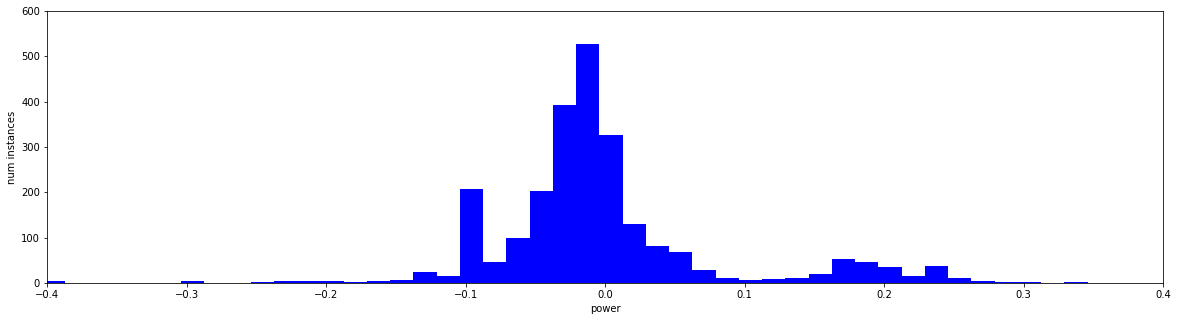

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

num_bins = 60
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
plt.axis([-0.4, 0.4, 0, 600])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

43752


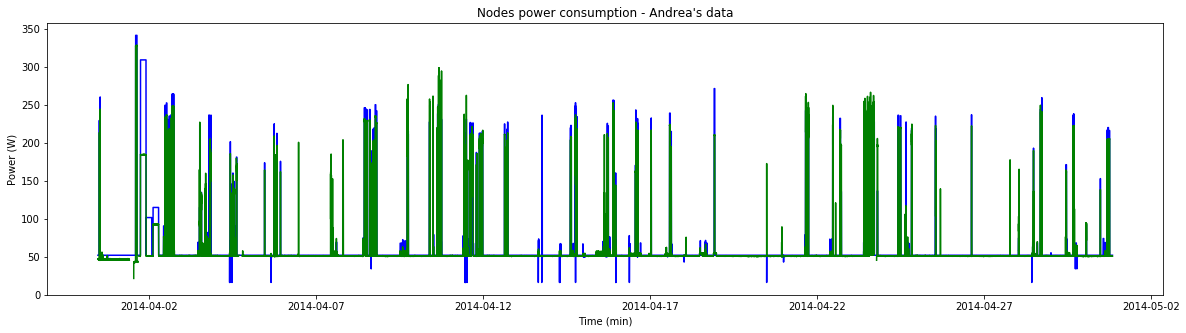

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

node_data = node_data[pd.to_datetime(node_data['timestamp']) >= start_time]
node_data = node_data[pd.to_datetime(node_data['timestamp']) <= end_time]

plt.rcParams['figure.figsize'] = (20,5)

X_AXIS_NAME = 'Time (min)'
Y_AXIS_NAME = 'Power (W)'
TITLE = 'Nodes power consumption - Andrea\'s data'

fig, ax = plt.subplots()
ax.xaxis.get_majorticklabels()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

dates = []
colors = ("blue", "green")

for ts in all_time_interval_power_consumption['timestamp']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
print(len(dates))

plt.plot(dates, all_time_interval_power_consumption['01_approx'], c=colors[0])

plt.plot(dates, all_time_interval_power_consumption['01_real'], c=colors[1])
#plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])


#fig.autofmt_xdate()
plt.xlabel(X_AXIS_NAME)
plt.ylabel(Y_AXIS_NAME)
plt.title(TITLE)

# function to show the plot
plt.show()
#fig.savefig('graph.png', dpi=fig.dpi)

# Debug

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import errno    
import os
import numpy as np
import math

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

'''
Author: Enrico Ceccolini
    TODO write the description
'''

datadir = "/datasets/eurora_data/db1/"
infile_jobs_to_nodes = datadir + "job_nodes.csv"

# settings
interval_comment = "Andrea"
suffix = "_1min_"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')

infile_large_jobs = datadir + "CPUs/" + interval_comment + "/large_jobs_real_pow_" + interval_comment + ".csv"

## notice that 43 doesn't exists in the db
nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
nodes=['01'] # test

In [ ]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

interval_large_jobs = pd.read_csv(infile_large_jobs, index_col=0)
merged_jobs_to_nodes = pd.merge(jobs_to_nodes_whole_data, interval_large_jobs, on='job_id_string')
print(merged_jobs_to_nodes.shape[0])

In [113]:
# merged_jobs_to_nodes

In [288]:
node = "01"
print(node)

jobs_to_node = merged_jobs_to_nodes[merged_jobs_to_nodes['node_id'] == int(node)]
infile_node = datadir + "CPUs/" + interval_comment + "/node" + node + suffix + interval_comment + "_active_cores_and_jobs"
node_data = pd.read_csv(infile_node + ".csv")
print("{}".format(node_data.shape[0]))
print("{}".format(jobs_to_node.shape[0]))

01
44641
384


In [290]:
node_start_time = node_data.iloc[0]['timestamp']
num_minutes = node_data.shape[0]
power_consumption = pd.Series(0, index=np.arange(num_minutes))
active_cores = pd.Series(0, index=np.arange(num_minutes))
print(num_minutes)
print(node_start_time)


44641
2014-03-31 00:00:00


In [136]:
jobs_to_node.head(1)

,node_id,job_id_string,ncpus,ngpus,nmics,mem_requested,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,time_req,exit_status,real_pow,runned_alone,real_pow_quality,n_2_1,n_2_2,n_3_1,gpu_req,mic_req
458,1,499903.node129,16,0,0,5242880,debug,2014-03-31 12:19:52,2014-03-31 12:19:54,2014-03-31 12:21:57,ralfieri@node129.eurora.cineca.it,1,16,5,00:30,COMPLETED,213.319134,True,1.0,1,0,0,NaN,NaN


In [137]:
i = 0
num_jobs = jobs_to_node.shape[0]
for index, row in jobs_to_node.iterrows():
    print("{}/{}   {}".format(i, num_jobs, row['job_id_string']))
    i = i + 1
    print(i)
    job_start_time = pd.to_datetime(row['run_start_time'])
    job_end_time = pd.to_datetime(row['end_time'])
    job_cores = row['ncpus']
    job_cores_total = row['cpu_req']
    #job_gpus = row['ngpus']
    #job_mics = row['nmics']
    job_power_consumption = row['real_pow'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
    # print(job_power_consumption)
    
    before_minutes = int((job_start_time - pd.to_datetime(node_start_time)) / np.timedelta64(1, 'm'))
    running_minutes = int((job_end_time - job_start_time) / np.timedelta64(1, 'm'))
    after_minutes = num_minutes - running_minutes - before_minutes
    
    print("{} - {} - {}".format(before_minutes, running_minutes, after_minutes))
    before_serie = pd.Series(0, index=np.arange(before_minutes))
    running_serie = pd.Series(job_power_consumption, index=np.arange(running_minutes))
    after_serie = pd.Series(0, index=np.arange(after_minutes))
    concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
    power_consumption = power_consumption.add(concat_series, fill_value=0)
    
    running_serie = pd.Series(job_cores, index=np.arange(running_minutes))
    concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
    active_cores = active_cores.add(concat_series, fill_value=0)

0/384   499903.node129
1
739 - 2 - 43900
1/384   499905.node129
2
743 - 1 - 43897
2/384   500234.node129
3
778 - 1 - 43862
3/384   500255.node129
4
820 - 17 - 43804
4/384   500269.node129
5
856 - 21 - 43764
5/384   500792.node129
6
1079 - 28 - 43534
6/384   502459.node129
7
2305 - 60 - 42276
7/384   502642.node129
8
3056 - 241 - 41344
8/384   502645.node129
9
2514 - 241 - 41886
9/384   502684.node129
10
2761 - 241 - 41639
10/384   503910.node129
11
3509 - 30 - 41102
11/384   504138.node129
12
3570 - 2 - 41069
12/384   504146.node129
13
3573 - 15 - 41053
13/384   504449.node129
14
3632 - 17 - 40992
14/384   504633.node129
15
3664 - 35 - 40942
15/384   504885.node129
16
3753 - 15 - 40873
16/384   504978.node129
17
3844 - 3 - 40794
17/384   505362.node129
18
3880 - 8 - 40753
18/384   505594.node129
19
3906 - 15 - 40720
19/384   505598.node129
20
3921 - 8 - 40712
20/384   505623.node129
21
3943 - 8 - 40690
21/384   507956.node129
22
4988 - 22 - 39631
22/384   508260.node129
23
5056 - 14 - 

189/384   589355.node129
190
21626 - 1 - 23014
190/384   589356.node129
191
21631 - 1 - 23009
191/384   589418.node129
192
21670 - 1 - 22970
192/384   589433.node129
193
21681 - 2 - 22958
193/384   589434.node129
194
21689 - 1 - 22951
194/384   589521.node129
195
22149 - 22 - 22470
195/384   589641.node129
196
22179 - 31 - 22431
196/384   589701.node129
197
22211 - 31 - 22399
197/384   589708.node129
198
22252 - 18 - 22371
198/384   589716.node129
199
22273 - 32 - 22336
199/384   589748.node129
200
22306 - 31 - 22304
200/384   589769.node129
201
22338 - 32 - 22271
201/384   589904.node129
202
22456 - 2 - 22183
202/384   589906.node129
203
22459 - 5 - 22177
203/384   589908.node129
204
22460 - 2 - 22179
204/384   589912.node129
205
22464 - 4 - 22173
205/384   589915.node129
206
22469 - 12 - 22160
206/384   589919.node129
207
22473 - 12 - 22156
207/384   589942.node129
208
22483 - 7 - 22151
208/384   589946.node129
209
22486 - 17 - 22138
209/384   589957.node129
210
22491 - 1 - 22149
210

379/384   629067.node129
380
44112 - 4 - 525
380/384   629105.node129
381
44187 - 4 - 450
381/384   629114.node129
382
44193 - 30 - 418
382/384   629142.node129
383
44229 - 30 - 382
383/384   629214.node129
384
44293 - 16 - 332


In [138]:
#power_consumption

In [139]:
for i in range(0, 17):
    active_cores[active_cores == i] += (3.23*16)*(16-i)/16

In [140]:
active_cores

0        51.68
1        51.68
2        51.68
3        51.68
4        51.68
5        51.68
6        51.68
7        51.68
8        51.68
9        51.68
10       51.68
11       51.68
12       51.68
13       51.68
14       51.68
15       51.68
16       51.68
17       51.68
18       51.68
19       51.68
20       51.68
21       51.68
22       51.68
23       51.68
24       51.68
25       51.68
26       51.68
27       51.68
28       51.68
29       51.68
30       51.68
31       51.68
32       51.68
33       51.68
34       51.68
35       51.68
36       51.68
37       51.68
38       51.68
39       51.68
40       51.68
41       51.68
42       51.68
43       51.68
44       51.68
45       51.68
46       51.68
47       51.68
48       51.68
49       51.68
50       51.68
51       51.68
52       51.68
53       51.68
54       51.68
55       51.68
56       51.68
57       51.68
58       51.68
59       51.68
60       51.68
61       51.68
62       51.68
63       51.68
64       51.68
65       51.68
66       5

In [141]:
power_consumption_with_idle = power_consumption
power_consumption_with_idle = power_consumption_with_idle.add(active_cores, fill_value=0)

44641


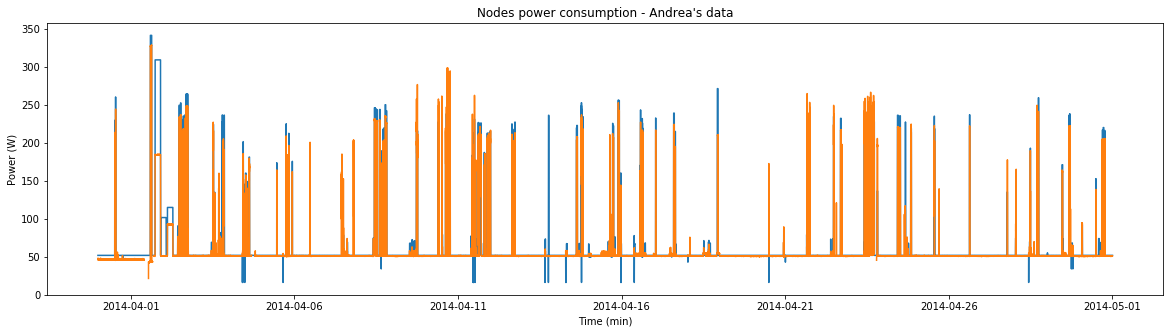

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

node_data = node_data[pd.to_datetime(node_data['timestamp']) >= start_time]
node_data = node_data[pd.to_datetime(node_data['timestamp']) <= end_time]

plt.rcParams['figure.figsize'] = (20,5)

X_AXIS_NAME = 'Time (min)'
Y_AXIS_NAME = 'Power (W)'
TITLE = 'Nodes power consumption - Andrea\'s data'

fig, ax = plt.subplots()
ax.xaxis.get_majorticklabels()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

dates = []

for ts in node_data['timestamp']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
print(len(dates))

plt.plot(dates, power_consumption_with_idle)

plt.plot(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])
#plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])


#fig.autofmt_xdate()
plt.xlabel(X_AXIS_NAME)
plt.ylabel(Y_AXIS_NAME)
plt.title(TITLE)

# function to show the plot
plt.show()
#fig.savefig('graph.png', dpi=fig.dpi)

44641


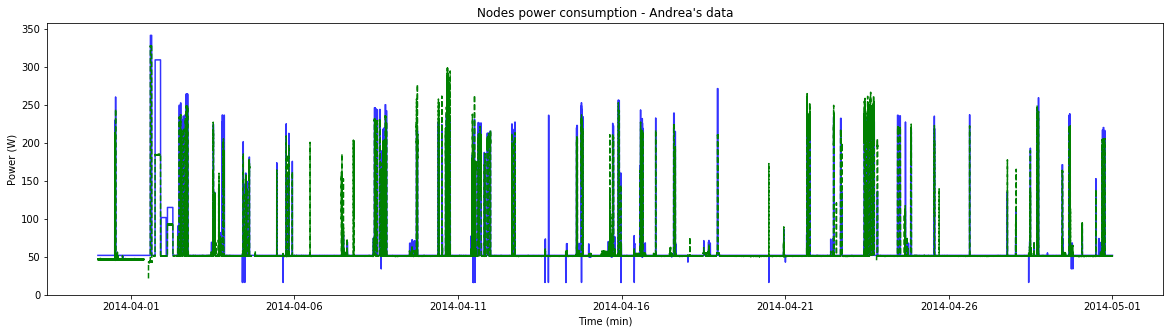

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

node_data = node_data[pd.to_datetime(node_data['timestamp']) >= start_time]
node_data = node_data[pd.to_datetime(node_data['timestamp']) <= end_time]

plt.rcParams['figure.figsize'] = (20,5)

X_AXIS_NAME = 'Time (min)'
Y_AXIS_NAME = 'Power (W)'
TITLE = 'Nodes power consumption - Andrea\'s data'

fig, ax = plt.subplots()
ax.xaxis.get_majorticklabels()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

colors = ("blue", "green")

dates = []

for ts in node_data['timestamp']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
print(len(dates))

plt.plot(dates, power_consumption_with_idle, alpha=0.8, c = colors[0])

plt.plot(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'], c = colors[1], ls='--')
#plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])


#fig.autofmt_xdate()
plt.xlabel(X_AXIS_NAME)
plt.ylabel(Y_AXIS_NAME)
plt.title(TITLE)

# function to show the plot
plt.show()
#fig.savefig('graph.png', dpi=fig.dpi)

In [263]:
node_real_pow = node_data['pow_tot_0'] + node_data['pow_tot_1']

differences = node_real_pow - power_consumption_with_idle



In [268]:
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df[0]

In [269]:
differences_norm

0       -0.002292
1       -0.003617
2       -0.004168
3       -0.006623
4       -0.005966
5       -0.003129
6       -0.005523
7       -0.005328
8       -0.005908
9       -0.005585
10      -0.004293
11      -0.006669
12      -0.006387
13      -0.006545
14      -0.006669
15      -0.004981
16      -0.003902
17      -0.004291
18      -0.004473
19      -0.003521
20      -0.003174
21      -0.004874
22      -0.004821
23      -0.003968
24      -0.003987
25      -0.003645
26      -0.003285
27      -0.003120
28      -0.003741
29      -0.002829
30      -0.002602
31      -0.004550
32      -0.004006
33      -0.005109
34      -0.004890
35      -0.004455
36      -0.004334
37      -0.005394
38      -0.004658
39      -0.004095
40      -0.004168
41      -0.004863
42      -0.005894
43      -0.005708
44      -0.005732
45      -0.005685
46      -0.005125
47      -0.005397
48      -0.005972
49      -0.006457
50      -0.004408
51      -0.006123
52      -0.006450
53      -0.005873
54      -0.006443
55      -0

In [270]:
differences_norm.sum()

-3.197442310920451e-14

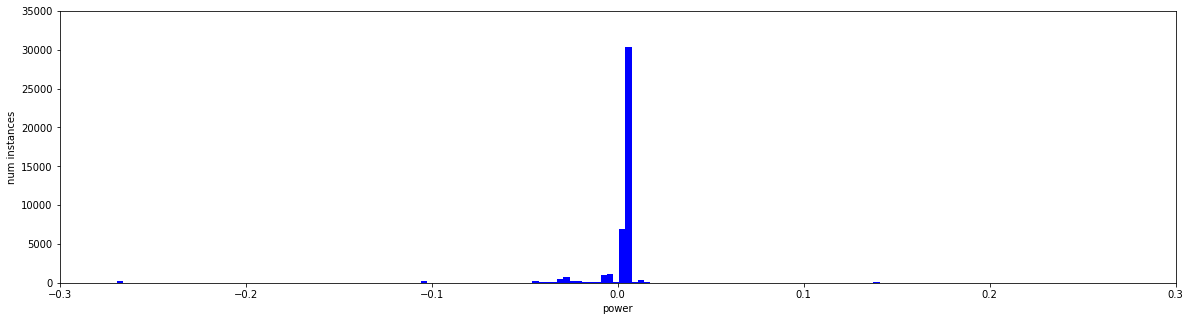

In [287]:
num_bins = 300
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
plt.axis([-0.3, 0.3, 0, 35000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

In [40]:
type(power_consumption)

pandas.core.series.Series

In [41]:
power_consumption[power_consumption > 1000]

2514    2346.365987
2515    2346.365987
2516    2346.365987
2517    2346.365987
2518    2346.365987
2519    2346.365987
2520    2346.365987
2521    2346.365987
2522    2346.365987
2523    2346.365987
2524    2346.365987
2525    2346.365987
2526    2346.365987
2527    2346.365987
2528    2346.365987
2529    2346.365987
2530    2346.365987
2531    2346.365987
2532    2346.365987
2533    2346.365987
2534    2346.365987
2535    2346.365987
2536    2346.365987
2537    2346.365987
2538    2346.365987
2539    2346.365987
2540    2346.365987
2541    2346.365987
2542    2346.365987
2543    2346.365987
2544    2346.365987
2545    2346.365987
2546    2346.365987
2547    2346.365987
2548    2346.365987
2549    2346.365987
2550    2346.365987
2551    2346.365987
2552    2346.365987
2553    2346.365987
2554    2346.365987
2555    2346.365987
2556    2346.365987
2557    2346.365987
2558    2346.365987
2559    2346.365987
2560    2346.365987
2561    2346.365987
2562    2346.365987
2563    2346.365987
